## Setup

In [75]:
from dotenv import load_dotenv
from utils import chat_interface
import os
import math
from datetime import datetime, timezone, timedelta
import time

from langgraph.checkpoint.memory import MemorySaver
from langgraph.checkpoint.sqlite import SqliteSaver
from langchain_community.vectorstores import Chroma
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_core.tools import tool
from langgraph.graph.message import MessagesState
from langchain_core.prompts import PromptTemplate
from langchain_core.prompts import ChatPromptTemplate
from langchain_chroma import Chroma
from langchain_core.documents import Document
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from pydantic import BaseModel, Field, ConfigDict
from typing import Dict, Any, List, Annotated, Literal, Tuple, Optional
from langchain_core.messages import (
    SystemMessage,
    HumanMessage,
    AIMessage
)
from langgraph.graph import START, END, StateGraph
from IPython.display import Image, display
from tavily import TavilyClient

### Parameters

In [ ]:
NUM_RETRIEVAL = 5
L1_TOPICS = {"how_to","troubleshooting_basic","status_check"}
L2_TOPICS = {"others","billing_payment"}
L3_TOPICS = {"outage","security"}
MAX_SUPPORT_AGENT_REPEAT = 2
TIME_LIMIT = timedelta(seconds=5)
CONFIDENCE_LEVEL_THRESHOLD = 0.70

### Setup LLMs for different Technical Support Level

In [74]:
load_dotenv()
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")
# llm_base_url = "https://openai.vocareum.com/v1"
llm_base_url = "https://api.openai.com/v1"

llm_small = ChatOpenAI(
    model="gpt-3.5-turbo",
    temperature=0.0,
    base_url=llm_base_url,
    api_key=OPENAI_API_KEY,
)

llm_medium = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.0,
    base_url=llm_base_url,
    api_key=OPENAI_API_KEY,
)

llm_large = ChatOpenAI(
    model="gpt-4o",
    temperature=0.0,
    base_url=llm_base_url,
    api_key=OPENAI_API_KEY,
)

embeddings_fn = OpenAIEmbeddings(
    model="text-embedding-3-large",
    base_url=llm_base_url,
    api_key=OPENAI_API_KEY,
)

### Create Vector Database Connection for RAG

In [4]:
chromadb_directory = "vectorstore"
collection_name = "knowledge_vecotr_store"
vector_store = Chroma(
    collection_name=collection_name,
    embedding_function=embeddings_fn,
    persist_directory=chromadb_directory,
)

## Agent State Management

State Memory

In [5]:
class TicketState(MessagesState):
    """State for the IT ticket workflow."""
    query: str
    current_answer: AIMessage
    # retrieved documents
    documents: List[Document]
    # routing signals
    intent: Literal['how_to', 'troubleshooting_basic', 'status_check', 
                    'security', 'billing_payment', 'outage', 'others'] = 'others'
    retrieval_score: float = 0.0
    answer_confidence: float = 0.0
    sentiment: float = 0.0
    # control/status
    assigned_group: Literal['start','L1', 'L2', 'L3', 'human'] = 'start'
    eval_status: Literal['resolved', 'needs_clarification', 'escalate'] = 'needs_clarification'
    turns_at_level: int = 0
    escalation_reason: Optional[Literal['low_confidence',
                                        'high_impact_or_sensitive',
                                        'unresolved_or_negative',
                                        'sla_breach']] = None
    # SLA/aging
    level_entered_at: datetime = datetime.now(timezone.utc)
    sla_minutes: int = 3  # example per level

Standardized Output for Subagent

In [80]:
class IntentOutput(BaseModel):
    """Standardized output to ensure it is from the possible values"""
    intent: Annotated[Literal['how_to','troubleshooting_basic','status_check','security','refund_high','outage','others'], 
                      Field(description="The intent of the IT ticket")]
    
class SentimentOutput(BaseModel):
    """Standardized output to ensure it is from the possible values"""
    sentiment: Annotated[float, Field(description="The user's sentiment",
                                      ge=-1.0,
                                      le=1.0)]

class ConfidenceOutput(BaseModel):
    """Standardized output to ensure it is from the possible values"""
    confidence: Annotated[float, Field(description="The confidence of answer toward the query",
                                      ge=0.0,
                                      le=1.0)]

class QueryAttributeOutput(BaseModel):
    """Standardized output"""
    intent: Annotated[Literal['how_to','troubleshooting_basic','status_check','security','billing_payment','outage','others'], 
                      Field(description="The intent of the IT ticket")]
    sentiment: Annotated[float, Field(description="The user's sentiment",
                                      ge=-1.0,
                                      le=1.0)]

class ChecklistOutput(BaseModel):
    """Standardized output"""
    checklist: Annotated[List[str], Field(description="Troubleshooting checklist items.")]

# Agent Tools

In [ ]:
@tool
def web_search(query: str, search_depth: str = "advanced") -> Dict:
    """
    Search the web using Tavily API
    args:
        query (str): Search query
        search_depth (str): Type of search - 'basic' or 'advanced' (default: advanced)
    """
    client = TavilyClient(api_key=TAVILY_API_KEY)
    
    # Perform the search
    search_result = client.search(
        query=query,
        search_depth=search_depth,
        include_answer=True,
        include_raw_content=False,
        include_images=False
    )
    
    # Format the results
    formatted_results = {
        "answer": search_result.get("answer", ""),
        "results": search_result.get("results", []),
        "search_metadata": {
            "timestamp": datetime.now().isoformat(),
            "query": query
        }
    }
    return formatted_results

@tool
def troubleshooting_checklist(intent: str, query: str) -> list[str]:
    """
    Generate a short, concrete troubleshooting checklist for this ticket.
    Intended for L2 support – focuses on step-by-step clarification.
    """
    # For the project, a prompt-based implementation is totally fine:
    prompt = f"""
        You are a customer support SOP assistant.
        Ticket intent: {intent}
        User query: {query}

        Produce 3–5 concrete troubleshooting steps the agent should follow.
        Each step must be short and actionable, not generic advice.
        Return ONLY a Python list of strings.
        """

    checklist = llm_medium.with_structured_output(ChecklistOutput).invoke(prompt).checklist  # or .invoke(...) depending on client
    return checklist

@tool
def resolution_policy_recommender(intent: str, sentiment: str, similarity: float) -> str:
    """
    Suggest an appropriate resolution type for this ticket:
    e.g., 'refund', 'credit', 'escalate_to_human', or 'explain_policy'.
    """
    prompt = f"""
        You are a senior support specialist.
        Ticket intent: {intent}
        Sentiment: {sentiment}
        Knowledge similarity score: {similarity}
        Based on common SaaS support policies, choose ONE of:
        - refund
        - partial_credit
        - escalate_to_human
        - explain_policy
        Return ONLY the chosen value.
        """
    return llm_medium.invoke(prompt).content.strip()

In [44]:
llm_large_web_search = llm_large.bind_tools([web_search])

## Agents

In [45]:
def query_assessment(state: TicketState):
    query = state["query"]

    # === Deterministic Query Assessment ===
    # (It must be assess for every query, there is no decision need to be made.  Therefore, no agent nor tool is required)

    # Obtain Retrieval Score and Documents
    retrievals = vector_store.similarity_search_with_score(
        query=query,
        k=num_retrieval,
        )

    documents = [ retrieval[0] for retrieval in retrievals ]
    similarity = [ 1-(retrieval[1]/math.sqrt(2)) for retrieval in retrievals ]  # ChromaDB uses L2 distance, it requires to perform this operation to convert to similarity
    max_similarity_score = max(similarity)

    # Intent Checking
    intent_prompt_template = """
        You are an expert evaluating the intent of IT ticket submitted by users and you are suppose to
        classify it as one of the following intent: ['how_to', 'troubleshooting_basic', 'status_check',
        'security', 'billing_payment', 'outage', 'others'].

        Output a single one of the above intent in the list, do not provide any explanation or description
        to your answer.

        Here is the user query:
        {query}
        """
    intent_prompt = PromptTemplate(
        template = intent_prompt_template,
        input_variables = ["query"],
        ).invoke({"query": query})
    response = llm_medium.with_structured_output(IntentOutput).invoke(intent_prompt)
    intent = response.intent

    # Sentiment Analysis
    sentiment_prompt_template = """
        You are an expert in marketing and assessing the sentiment of the customer.  You need to provide a score between
        -1 to 1 where -1 is upset/angry/negative where 1 is happy/optimisitic/positive.

        Output a single number, do not provide any explanation or description to your answer.

        Here is the user query:
        {query}
        """
    sentiment_prompt = PromptTemplate(
        template = sentiment_prompt_template,
        input_variables = ["query"],
        ).invoke({"query": query})
    response = llm_medium.with_structured_output(SentimentOutput).invoke(sentiment_prompt)
    sentiment = response.sentiment
        
    ai_message = AIMessage(content=f"intent: {intent}, retrieval_score: {max_similarity_score}, sentiment: {sentiment}")

    return {"intent": intent,
            "retrieval_score": max_similarity_score,
            "sentiment": sentiment,
            "documents": documents,
            "messages": ai_message,
            "eval_status": 'needs_clarification'}

In [47]:
def initial_routing(state: TicketState):
    score = state["retrieval_score"]
    intent = state["intent"]
    if (score < 0.4) or (intent in L3_TOPICS):
        return "l3_agent"
    if intent in L2_TOPICS:
        return "l2_agent"
    return "l1_agent"

In [62]:
def l1_agent(state: TicketState):
    assigned_group = state["assigned_group"]
    turns_at_level = state["turns_at_level"]
    query = state["query"]
    documents = state["documents"]
    level_entered_at = state["level_entered_at"]

    # Assess Number of Turns
    if assigned_group == 'L1':
        turns_at_level += turns_at_level
    else:
        turns_at_level = 1
        assigned_group = 'L1'
        level_entered_at = datetime.now(timezone.utc)

    # Augment + Generation
    docs_content = "\n\n".join(doc.page_content for doc in documents)
    template = ChatPromptTemplate([
        ("system", "You are an assistant for question-answering tasks."),
        ("human", """
            Use the following pieces of retrieved context to answer the question.
            If you don't know the answer, just say that you don't know.
            Use three sentences maximum and keep the answer concise.
            # Question: -> {query}
            # Context: -> {context}
            # Answer:
            """
            ),
        ])
    messages = template.invoke(
        {"context": docs_content, "query": query}
        ).to_messages()
    
    # L1 use the most basic model
    ai_message = llm_small.invoke(messages)

    return {"messages": ai_message,
            "current_answer": ai_message,
            "turns_at_level": turns_at_level,
            "level_entered_at": level_entered_at,
            "assigned_group": assigned_group}

In [63]:
def l2_agent(state: TicketState):
    assigned_group = state["assigned_group"]
    turns_at_level = state["turns_at_level"]
    query = state["query"]
    documents = state["documents"]
    level_entered_at = state["level_entered_at"]

    # Assess Number of Turns
    if assigned_group == 'L2':
        turns_at_level += turns_at_level
    else:
        turns_at_level = 1
        assigned_group = 'L2'
        level_entered_at = datetime.now(timezone.utc)

    # Augment + Generation
    docs_content = "\n\n".join(doc.page_content for doc in documents)
    template = ChatPromptTemplate([
        ("system", "You are an assistant for question-answering tasks."),
        ("human", """
            Use the following pieces of retrieved context to answer the question.
            If you don't know the answer, just say that you don't know.
            Use three sentences maximum and keep the answer concise.
            # Question: -> {query}
            # Context: -> {context}
            # Answer:
            """
            ),
        ])
    messages = template.invoke(
        {"context": docs_content, "query": query}
        ).to_messages()
    
    # L2 use a better model
    ai_message = llm_medium.invoke(messages)

    return {"messages": ai_message,
            "current_answer": ai_message,
            "turns_at_level": turns_at_level,
            "level_entered_at": level_entered_at,
            "assigned_group": assigned_group}


In [64]:
def l3_agent(state: TicketState):
    assigned_group = state["assigned_group"]
    turns_at_level = state["turns_at_level"]
    query = state["query"]
    documents = state["documents"]
    level_entered_at = state["level_entered_at"]

    # Assess Number of Turns
    if assigned_group == 'L3':
        turns_at_level += turns_at_level
    else:
        turns_at_level = 1
        assigned_group = 'L3'
        level_entered_at = datetime.now(timezone.utc)

    # Augment + Generation
    docs_content = "\n\n".join(doc.page_content for doc in documents)
    template = ChatPromptTemplate([
        ("system", "You are an assistant for question-answering tasks."),
        ("human", """
            Use the following pieces of retrieved context to answer the question.
            If you don't know the answer, just say that you don't know.
            Use `web_search` tool to search for relevant informaiton if it helps.

            Use three sentences maximum and keep the answer concise.
            # Question: -> {query}
            # Context: -> {context}
            # Answer:
            """
            ),
        ])
    messages = template.invoke(
        {"context": docs_content, "query": query}
        ).to_messages()
    
    # L3 uses the largest model together with websearch tool
    ai_message = llm_large_web_search.invoke(messages)

    return {"messages": ai_message,
            "current_answer": ai_message,
            "turns_at_level": turns_at_level,
            "level_entered_at": level_entered_at,
            "assigned_group": assigned_group}



In [65]:
def human_support(state: TicketState):
    human_message = HumanMessage(content="System will send an email to human support.")
    return {"messages": human_message}

In [66]:
def response_evaluator(state: TicketState):

    # Evaluate the confidence level
    query = state["query"]
    answer = state["current_answer"]
    eval_status = state["eval_status"]
    confidence_prompt_template = """
        You are an expert in quality control to evaluate whether the support team had been doing a good job for providing
        the relevant response to the user.  You need to provide a score between 0 to 1, where 0 corresponse to an answer 
        where it is completely irrelevant to the querey, where 1 is spot on and it solves the user's query.

        Here is the user query:
        {query}

        Here is the support team's response:
        {answer}
        """
    confidence_prompt = PromptTemplate(
        template = confidence_prompt_template,
        input_variables = ["query","answer"],
        ).invoke({"query": query, "answer": answer})
    response = llm_medium.with_structured_output(ConfidenceOutput).invoke(confidence_prompt)
    confidence = response.confidence

    # Routing logic
    if confidence > CONFIDENCE_LEVEL_THRESHOLD:
        eval_status = 'resolved'
    if state["turns_at_level"] >= MAX_SUPPORT_AGENT_REPEAT:
        eval_status = 'escalate'
    if datetime.now(timezone.utc) - state["level_entered_at"] > TIME_LIMIT:
        eval_status = 'escalate'

    ai_message = AIMessage(content=f"confidence: {confidence}")

    return {"messages": ai_message,
            "answer_confidence": confidence,
            "eval_status": eval_status}

In [67]:
def escalation_routing(state: TicketState):
    current_support_level = state['assigned_group']
    support_agent_rank = ['L1','L2','L3','human']
    rank_to_node = {'L1':'l1_agent','L2':'l2_agent','L3':'l3_agent','human':'human_support'}

    if state["eval_status"] == 'resolved':
        return END

    if state["eval_status"] == 'escalate':
        rank = support_agent_rank[support_agent_rank.index(current_support_level) + 1]
        node = rank_to_node[rank]
        return node
    
    return rank_to_node[current_support_level]

## Workflow

In [68]:
workflow = StateGraph(TicketState)

workflow.add_node("query_assessment", query_assessment)
workflow.add_node("l1_agent",l1_agent)
workflow.add_node("l2_agent",l2_agent)
workflow.add_node("l3_agent",l3_agent)
workflow.add_node("human_support",human_support)
workflow.add_node("response_evaluator",response_evaluator)

workflow.add_edge(START,"query_assessment")
workflow.add_edge("l1_agent","response_evaluator")
workflow.add_edge("l2_agent","response_evaluator")
workflow.add_edge("l3_agent","response_evaluator")


workflow.add_conditional_edges(
    source="query_assessment",
    path=initial_routing,
    path_map=["l1_agent","l2_agent","l3_agent","human_support"]
)

workflow.add_conditional_edges(
    source="response_evaluator",
    path=escalation_routing,
    path_map=["l1_agent","l2_agent","l3_agent","human_support",END]
)

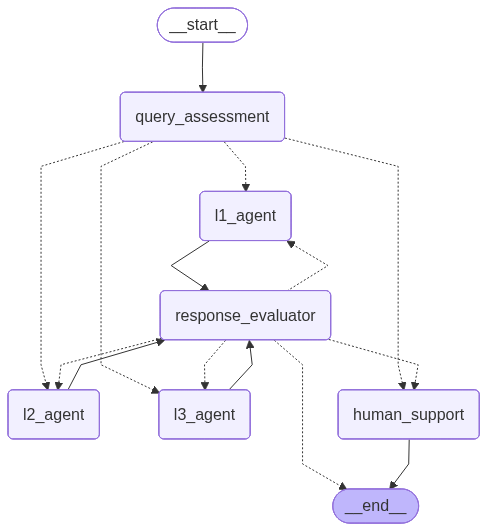

In [69]:
graph = workflow.compile()
display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

In [70]:
query = "Hi, I have a question regarding the billing for the events I attended last month. There seems to be a discrepancy in the charges, and I would like to understand the breakdown of the costs. Could you please provide a detailed billing statement? Thank you."

initial_state = {
    "query": query,
    "messages": [],
    "current_answer": AIMessage(content=""),
    "documents": [],
    "intent": "others",
    "retrieval_score": 0.0,
    "sentiment": 0.0,
    "assigned_group": "start",
    "eval_status": "needs_clarification",
    "turns_at_level": 0,
    "escalation_reason": None,
    "level_entered_at": datetime.now(timezone.utc),
    "sla_minutes": 3
}

output = graph.invoke(initial_state)

In [71]:
output

{'messages': [AIMessage(content='intent: refund_high, retrieval_score: 0.2638274033811877, sentiment: 0.0', additional_kwargs={}, response_metadata={}, id='5ad8e828-e233-43d0-891c-be071854e92d'),
  AIMessage(content='To address the billing discrepancy for the events you attended last month, first review your billing history in the CultPass app. If discrepancies are found, contact support with your transaction details for a faster resolution. For a detailed billing statement, reaching out to CultPass support directly would be the best course of action.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 62, 'prompt_tokens': 587, 'total_tokens': 649, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_83554

In [ ]:
# IDEALLY YOUR ONLY IMPORT HERE IS:
# from agentic.workflow import orchestrator

from agentic.workflow import orchestrator

In [ ]:
chat_interface(orchestrator, "1")

In [ ]:
list(orchestrator.get_state_history(
    config = {
        "configurable": {
            "thread_id": "1",
        }
    }
))[0].values["messages"]

---

# Testing Code

In [ ]:
class IntentOutput(BaseModel):
    """Standardized output to ensure it is from the possible values"""
    intent: Annotated[Literal['how_to','troubleshooting_basic','status_check','security','refund_high','outage','others'], 
                      Field(description="The intent of the IT ticket")]

query = "Hi, I have a question regarding the billing for the events I attended last month. There seems to be a discrepancy in the charges, and I would like to understand the breakdown of the costs. Could you please provide a detailed billing statement? Thank you."

# === Deterministic Query Assessment ===
# (It must be assess for every query, there is no decision need to be made.  Therefore, no agent nor tool is required)

# Obtain Retrival Score and Documents
retrivals = vector_store.similarity_search_with_score(
    query=query,
    k=NUM_RETRIEVAL,
    )

documents = [ retrival[0] for retrival in retrivals ]
similarity = [ 1-(retrival[1]/math.sqrt(2)) for retrival in retrivals ]  # ChromaDB uses L2 distance, it requires to perform this operation to convert to similarity
max_similarity_score = max(similarity)

# Intent Checking
intent_prompt_template = """
    You are an expert evaluating the intent of IT ticket submitted by users and you are suppose to
    classify it as one of the following intent: ['how_to', 'troubleshooting_basic', 'status_check',
    'security', 'billing_payment', 'outage', 'others'].

    Output a single one of the above intent in the list, do not provide any explanation or description
    to your answer.

    Here is the user query:
    {query}
    """
intent_prompt = PromptTemplate(
    template = intent_prompt_template,
    input_variables = ["query"],
    ).invoke({"query": query})
response = llm_medium.with_structured_output(IntentOutput).invoke(intent_prompt)
intent = response.intent

# Sentiment Analysis
sentiment_prompt_template = """
    You are an expert in marketing and assessing the sentiment of the customer.  You need to provide a score between
    -1 to 1 where -1 is upset/angry/negative where 1 is happy/optimisitic/positive.

    Output a single number, do not provide any explanation or description to your answer.

    Here is the user query:
    {query}
    """
sentiment_prompt = PromptTemplate(
    template = prompt_template,
    input_variables = ["query"],
    ).invoke({"query": query})
response = llm_medium.with_structured_output(SentimentOutput).invoke(sentiment_prompt)
sentiment = response.sentiment
    
ai_message = AIMessage(content=f"intent: {intent}, retrieval_score: {max_similarity_score}, sentiment: {sentiment}")

In [ ]:
response

In [ ]:
a = datetime.now(timezone.utc)
time.sleep(2)
b = datetime.now(timezone.utc)
elapse = b - a
time_expire = timedelta(seconds=2)
elapse > time_expire

In [ ]:
@tool
def knowledge_retrival(query: str) -> List[dict]:
    """
    Evaluate whether the knowledge base has enough content to address the query and return the relevant content indices.

    Args:
        query (str): The user query string
    
    Returns:
        retrival (List[tuple[Document,float]]): Response from the ChromaDB database for the retrieved documents and the corresponding
                                                distance measure.
    """
    results = vector_store.similarity_search_with_score(
        query=query,
        k=num_retrieval,
    )

    # Convert the output to recognizable types for Pydantic to work
    retrival = []
    for doc, score in results:
        retrival.append({
            "document": {
                "id": int(doc.id),
                "page_content": doc.page_content,
                "tags": doc.metadata.get("tags","")
            },
            "score": score
        })
    return retrival

def run_retrieval(query: str):
    return {"query": query, "retrival": knowledge_retrival.func(query)}

class VectorDocument(BaseModel):
    """The contents of a retrieved LangChain Document."""
    id: int
    page_content: str
    tags: str

class SearchResultItem(BaseModel):
    """Represents the tuple (Document, score) as a JSON object."""
    document: VectorDocument = Field(description="The document content and metadata.")
    score: float = Field(description="The L2 distance.")

class QueryAttributeOutput(BaseModel):
    retrival: List[SearchResultItem] = Field(min_length=num_retrieval, description="List of retrieved document and score pairs.")

query = "Hi, I have a question regarding the billing for the events I attended last month. There seems to be a discrepancy in the charges, and I would like to understand the breakdown of the costs. Could you please provide a detailed billing statement? Thank you."

prompt = ChatPromptTemplate.from_template(
    "Return the provided retrievals verbatim in the output schema.\nRetrievals:\n{retrival}"
    )

pipeline = (
    RunnableLambda(lambda q: {"retrival": knowledge_retrival.func(q)})
    | prompt
    | llm_medium.with_structured_output(QueryAttributeOutput)
    )
retrivals = pipeline.invoke(query)


In [ ]:
retrivals.retrival

In [ ]:

query = "Hi, I have a question regarding the billing for the events I attended last month. There seems to be a discrepancy in the charges, and I would like to understand the breakdown of the costs. Could you please provide a detailed billing statement? Thank you."

retrivals = vector_store.similarity_search_with_score(
    query=query,
    k=num_retrieval,
    )
similarity = [ 1-(retrival[1]/math.sqrt(2)) for retrival in retrivals ]  # ChromaDB uses L2 distance, it requires to perform this operation to convert to similarity
max_similarity_score = max(similarity)

# Intent Checking and Sentiment Analysis
llm_initial_evaluator = llm_medium.bind_tools([intent_check,sentiment_analyzer])
prompt_template = """
    You are a IT ticket evaluation agent, given the user query:
    {query}

    Use the following tools to provide insights for the user query:
        (1) Use `intent_check` to identify the "intent" attribute of the given query
        (2) Use `sentiment_analyzer` to estimate the "sentiment" of the given query
    """
prompt = PromptTemplate(
    template = prompt_template,
    input_variables = ["query"],
    ).invoke({"query": query})
response = llm_initial_evaluator.with_structured_output(QueryAttributeOutput).invoke(prompt)

In [ ]:
retrivals

In [ ]:
query = "Hi, I have a question regarding the billing for the events I attended last month. There seems to be a discrepancy in the charges, and I would like to understand the breakdown of the costs. Could you please provide a detailed billing statement? Thank you."

class VectorDocument(BaseModel):
    """The contents of a retrieved LangChain Document."""
    id: int
    page_content: str
    tags: str

class SearchResultItem(BaseModel):
    """Represents the tuple (Document, score) as a JSON object."""
    document: VectorDocument = Field(description="The document content and metadata.")
    score: float = Field(description="The L2 distance.")

class QueryAttributeOutput(BaseModel):
    retrival: Annotated[List[SearchResultItem], Field(description="List of retrieved document and score pairs.")]

results = vector_store.similarity_search_with_score(
    query=query,
    k=num_retrieval,
)

# Convert the output to recognizable types for Pydantic to work
retrival = []
for doc, score in results:
    retrival.append({
        "document": {
            "id": int(doc.id),
            "page_content": doc.page_content,
            "tags": doc.metadata.get("tags")
        },
        "score": score
    })

QueryAttributeOutput(retrival=retrival)

In [ ]:
len(retrival)

In [ ]:
QueryAttributeOutput(retrival=retrival)

In [ ]:
query = "Hi, I have a question regarding the billing for the events I attended last month. There seems to be a discrepancy in the charges, and I would like to understand the breakdown of the costs. Could you please provide a detailed billing statement? Thank you."
prompt_template = """
    You are an expert evaluating the intent of IT ticket submitted by users and you are suppose to
    classify it as one of the following intent: ['how_to', 'troubleshooting_basic', 'status_check',
    'security', 'refund_high', 'outage', 'others'].

    Output a single one of the above intent in the list, do not provide any explanation or description
    to your answer.

    Here is the user query:
    {query}
    """
prompt = PromptTemplate(
    template = prompt_template,
    input_variables = ["query"],
    ).invoke({"query": query})
response = llm_medium.with_structured_output(IntentOutput).invoke(prompt)


In [ ]:
query = "Hi, I have a question regarding the billing for the events I attended last month. There seems to be a discrepancy in the charges, and I would like to understand the breakdown of the costs. Could you please provide a detailed billing statement? Thank you."
query = "You are so useless!"
prompt_template = """
    You are an expert in marketing and assessing the sentiment of the customer.  You need to provide a score between
    -1 to 1 where -1 is upset/angry/negative where 1 is happy/optimisitic/positive.

    Output a single number, do not provide any explanation or description to your answer.

    Here is the user query:
    {query}
    """
prompt = PromptTemplate(
    template = prompt_template,
    input_variables = ["query"],
    ).invoke({"query": query})
response = llm_medium.with_structured_output(SentimentOutput).invoke(prompt)
sentiment = response.sentiment
sentiment

In [ ]:
@tool
def knowledge_retrival(query: str):
    """
    Evaluate whether the knowledge base has enough content to address the query and return the relevant content indices.

    Args:
        query (str): The user query string
    
    Returns:
        retrival (List[tuple[Document,float]]): Response from the ChromaDB database for the retrieved documents and the corresponding
                                                distance measure.
    """
    results = vector_store.similarity_search_with_score(
        query=query,
        k=num_retrieval,
    )

    # Convert the output to recognizable types for Pydantic to work
    retrival = []
    for doc, score in results:
        safe_metadata = json.loads(json.dumps(doc.metadata, default=str))
        retrival.append({
            "document": {
                "id": int(doc.id),
                "page_content": doc.page_content,
                "tags": doc.metadata.get("tags","")
            },
            "score": score
        })
    return retrival

class VectorDocument(BaseModel):
    """The contents of a retrieved LangChain Document."""
    id: int
    page_content: str
    tags: str

class SearchResultItem(BaseModel):
    """Represents the tuple (Document, score) as a JSON object."""
    document: VectorDocument = Field(description="The document content and metadata.")
    score: float = Field(description="The L2 distance.")

class QueryAttributeOutput(BaseModel):
    retrival: List[SearchResultItem] = Field(min_length=num_retrieval, description="List of retrieved document and score pairs.")

query = "Hi, I have a question regarding the billing for the events I attended last month. There seems to be a discrepancy in the charges, and I would like to understand the breakdown of the costs. Could you please provide a detailed billing statement? Thank you."
llm_initial_evaluator = llm_medium.bind_tools([knowledge_retrival])
# Evaluate Retrival Score, Intent, Sentiment of the Query
prompt_template = """
    You are a IT ticket evaluation agent, given the user query:
    {query}

    Use `knowledge_retrival` to extract "retrival" attribute from the ChromaDB knowledge database
    """
prompt = PromptTemplate(
    template = prompt_template,
    input_variables = ["query"],
    ).invoke({"query": query})

response = llm_initial_evaluator.with_structured_output(QueryAttributeOutput).invoke(prompt)

In [ ]:
len(response.retrival)

In [ ]:
response.retrival